<a href="https://colab.research.google.com/github/AbdulrhmnGhanem/bdd100k-trajectories/blob/main/satellite_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* I managed to sample the ground images at $1$ sample per $10m$.
* The next step is to get the satellite images of the trajectory.

## The Approach
1. Take the `trajectories_with_timestamps` generated in the [timestamps.ipynb](https://colab.research.google.com/drive/1DACbOOUVDfqEiFVnMmY6b41iIxzZFC-h?usp=sharing).
2. Split each trajectory into $50m$ chucks, i.e., each sub-trajectory in the trajectory will include 5 elements from the trajectory array. We want to tolerate trajectories with displacement not a multiple of $50m$ this means sub-trajectories can be at most $50m$ and at least $10m$
> $10m \le sub \ trajectory \ length \le 50m $.
3. We will have a problem with the points in which we don't have a GPS location, we need to figure out what algorithm should be used to estimate the GPS location of intermediate sampling points.
  * http://www.movable-type.co.uk/scripts/latlong.html
  * https://www.igismap.com/formula-to-find-bearing-or-heading-angle-between-two-points-latitude-longitude
4. If we have the GPS location of all the intermediate sampling points, we can simply call the API to get the satellite images with the parameters we have agreed upon.
> `zoom  = 20` \
> `scale =  1`  \
> `size  = 800x800`

5. Resize the images to `400:-1`.
6. Upload it.

_Preferably doing 5 and 6 as a pipeline._



In [1]:
!pip install great-circle-calculator

In [2]:
import pickle

from google.colab import drive

drive.mount('/content/drive')

with open('/content/drive/MyDrive/selected_trajectories.pkl', 'rb') as f:
  selected_trajectories = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from getpass import getpass

API_KEY = getpass("Enter Google Maps API key: ")

Enter Google Maps API key: ··········


In [4]:
from typing import List, Tuple
from itertools import accumulate, count
from functools import lru_cache
from math import isclose
import io


import geopy.distance
from great_circle_calculator.great_circle_calculator import intermediate_point
import PIL
import imageio
import requests
from numba import njit, typed, types



ROUNDING_NDIGITS = 2
AERIAL_GROUP_DISTANCE_COVERAGE = 50



def trajectory_to_points(trajectory: Tuple[str, List]) -> List[Tuple[float, float]]:
  "Return list of GPS points from a trajectory"
  return [(point["latitude"], point["longitude"]) for point in trajectory[1]][0:40]

def get_trajectory_running_distance(trajectory: Tuple[str, List]) -> List[float]:
  """
  Get the running distance of the trajectory at each second of the video
  :param: points - list of GPS points, [](latitude, longitude)
  """
  points = trajectory_to_points(trajectory)
  assert len(points) == 40, f"Found {len(points)} instead!"
  # prepadding a zero at the beginning because the running distance at the start is zero.
  adjacent_distance = [geopy.distance.distance(p1, p2).meters for p1, p2 in zip(points, points[1:])]
  running_distance = accumulate(adjacent_distance)
  adjusted_running_distance = [0] + [round(d, ROUNDING_NDIGITS) for d in running_distance]
  assert len(adjusted_running_distance) == 40, f"Each video is 40s each, sample each second. Got {len(adjusted_running_distance)} points"
  return adjusted_running_distance

def get_aerial_groups_gps_locations(trajectory):
  aerial_sampling_points = count(AERIAL_GROUP_DISTANCE_COVERAGE, AERIAL_GROUP_DISTANCE_COVERAGE)
  current_sampling_point = next(aerial_sampling_points)
  trajectory_running_distance = get_trajectory_running_distance(trajectory)
  assert len(trajectory_running_distance) == 40 

  aerial_groups = []
  for idx, d in enumerate(trajectory_running_distance):
    if d <= current_sampling_point:
      continue
    if d > (current_sampling_point + AERIAL_GROUP_DISTANCE_COVERAGE):
      # Here we need to handle intermediate points where we don't have GSP locations.
      distance_between_current_and_previous_trajectory_points = trajectory_running_distance[idx] - trajectory_running_distance[idx-1]
      distance_between_current_sampling_point_and_previous_trajectory_point = current_sampling_point - trajectory_running_distance[idx-1]
      previous_trajectory_point_location = trajectory[1][idx-1]["latitude"], trajectory[1][idx-1]["longitude"]
      current_trajectory_point_locaiton =  trajectory[1][idx]["latitude"], trajectory[1][idx]["longitude"]

      if isclose(distance_between_current_and_previous_trajectory_points, 0):
        continue
      # The greate circle calculator uses (long, lat) while we use (lat, long) format for GPS locations.
      gps_location = intermediate_point(
          previous_trajectory_point_location[::-1],
          current_trajectory_point_locaiton[::-1],
          distance_between_current_sampling_point_and_previous_trajectory_point / distance_between_current_and_previous_trajectory_points,
          )[::-1]
    else:
      gps_location = trajectory[1][idx]["latitude"], trajectory[1][idx]["longitude"]
   
    aerial_groups.append(gps_location)
    current_sampling_point = next(aerial_sampling_points)

  return trajectory[0], aerial_groups

def mark_trajectory(points, *,zoom, scale, size):
  base_url = "https://maps.googleapis.com/maps/api/staticmap"
  key=API_KEY
  markers = '|'.join(f"{x}, {y}" for x, y in points)

  img_url = f"{base_url}?key={key}&zoom={zoom}&scale={scale}" \
                f"&size={size}&maptype=satellite&format=png" \
                f"&visual_refresh=true&markers={markers}"
  return PIL.Image.open(
      io.BytesIO(requests.get(img_url).content)).convert('RGB')

In [5]:
sample_trajectory = selected_trajectories[100]
ground_truth_points = [(p["latitude"], p["longitude"]) for p in sample_trajectory[1]]
aerial_sampling_points = get_aerial_groups_gps_locations(sample_trajectory)[1]

# Ground truth trajectory

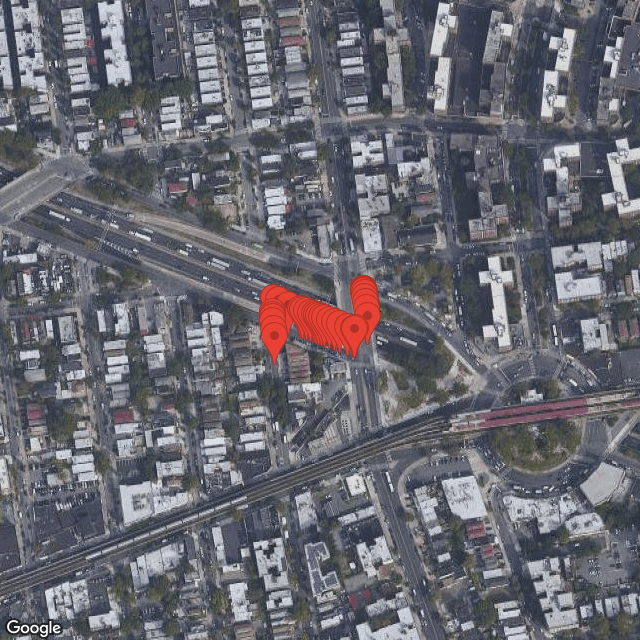

In [6]:
mark_trajectory(ground_truth_points, zoom=17, scale=1, size="800x800")  # Ground truth trajectory.

# The points at which we are taking aerial snapshots

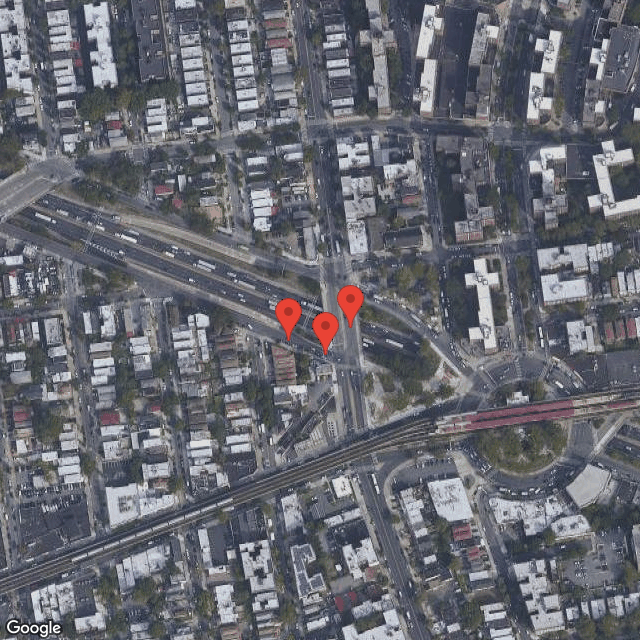

In [7]:
mark_trajectory(aerial_sampling_points, zoom=17, scale=1, size="800x800")  # The points at which we are taking aerial snapshots.

## Store the result

In [8]:
aerial_sampling_points = [get_aerial_groups_gps_locations(trajectory) for trajectory in selected_trajectories]

with open("/content/drive/MyDrive/aerial_sampling_points.pkl", 'wb') as f:
  pickle.dump(aerial_sampling_points, f)

In [9]:
aerial_sampling_points[0]

('75c97fc6-2b1b8514.json',
 [(40.7456704992665, -73.92103978781586),
  (40.746158928264656, -73.92094322001155),
  (40.74657609345098, -73.92086074184948),
  (40.746777305308036, -73.92082096004432),
  (40.747284123014666, -73.92071942784335),
  (40.747735620463494, -73.9206298267668)])